# The Notebook file where I am going to create the model and train it

The plan is to create a human visual system like replica for computer to look through camera working as their eyes and understand the mood by reading on facial expression.

I will load the data here, make it ready or the model, then create the model and train it here. After it is done I will save the trained parameters to use in a python script which can understand the facial expression with the help of camera and the OpenCV module.

In [1]:
# performing the imports we may need to use later in the notebook

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch, os
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

## 1. Getting the Data and Understanding it

After looking around the internet I found a dataset in csv format known as FER2013 containing pixel values of the photos and their respective classes.

In [2]:
# Let us first load the dataset
df = pd.read_csv('../input/fer2013/fer2013.csv') # This is because I used the notebook to train on kaggle

# df = pd.read_csv('/data/fer2013.csv')

# and then take a look at the csv dataframe
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


After taking a look at the data frame we can see clearly that there are 3 columns in the 
frame first has the index number of the classes that is 0 for happy face and 1 for sad but we do not know which is what yet so we will categorize it ourselves a little later

The second column contains the pixel values for the photo of the faces with the respective reactions and usage column states which data rows are for testing which are for training.

Let us try to take out someinsights from the dataset

In [3]:
print('Total lenth of dataset: ', len(df.Usage), '\n') # Which is actually also the lenth of total dataframe
print('Total Categories we have: ', df.Usage.unique())
print('Number of data in each category: ', '{ Training: ', len(df[df.Usage == 'Training']), ' PublicTest: ', len(df[df.Usage == 'PublicTest']), ' PrivateTest: ', len(df[df.Usage == 'PrivateTest']), '}\n')
print('Total Expression Classes we have: ', df.emotion.unique(), '\n')
print('Type of the pixel data is: ', type(df.pixels[0]))

Total lenth of dataset:  35887 

Total Categories we have:  ['Training' 'PublicTest' 'PrivateTest']
Number of data in each category:  { Training:  28709  PublicTest:  3589  PrivateTest:  3589 }

Total Expression Classes we have:  [0 2 4 6 3 5 1] 

Type of the pixel data is:  <class 'str'>


Now let us try to understand which clas of the expression represents which expression ourselves!

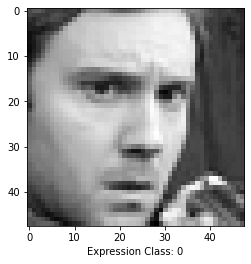

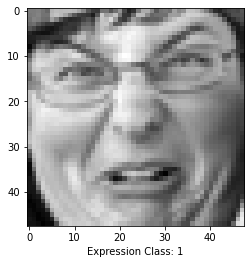

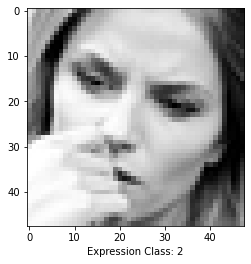

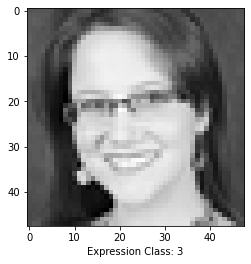

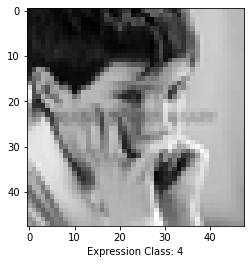

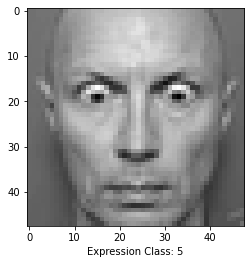

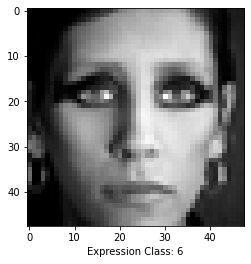

In [4]:
# since the pixels are in a single long presentation this function will turn it to a matrix of 48x48
def makemtrx(lst, n=48):
    for i in range(0, 48*48, n):  
        yield lst[i:i + n] 

# This function will help to show the images
def showimg(data):
    pixel = [int(i) for i in data[1].split(' ')]
    pixel = np.array(list(makemtrx(pixel)))
    plt.imshow(pixel, cmap='gray')
    plt.xlabel(f'Expression Class: {data[0]}')
    plt.plot()

for i in range(7):
    plt.figure()
    showimg(df[df.emotion == i].values[0])

After looking at the expressionin the photos i can conclude the classes for the expression below.

In [5]:
classes = {
    0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'
}

Now let me get the data ready for the model!!

In [6]:
# getting the dataset ready
df_train = pd.concat([df[(df.Usage == 'Training')], df[df.Usage == 'PublicTest']], ignore_index=True).drop(['Usage'], axis=1)
df_test = df[df.Usage == 'PrivateTest'].drop(['Usage'], axis=1).reset_index().drop(['index'], 1)

# differentiating between labels and images
train_images = df_train.iloc[:, 1]
train_labels = df_train.iloc[:, 0]
test_images = df_test.iloc[:, 1]
test_labels = df_test.iloc[:, 0]

Now we will create a class for the dataset!

In [7]:
# this is for the transforms
train_trfm = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomCrop(48, padding=4, padding_mode='reflect'),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5), inplace=True)
    ])
val_trfm = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])

In [8]:
# Creating the class for our dataset for the FER
class FERDataset(Dataset):
    
    def __init__(self, images, labels, transforms):
        self.X = images
        self.y = labels
        self.transforms = transforms
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        data = [int(m) for m in self.X[i].split(' ')]
        data = np.asarray(data).astype(np.uint8).reshape(48,48,1)
        data = self.transforms(data)
        label = self.y[i]
        return (data, label)
    
# assigning the transformed data
train_data = FERDataset(train_images, train_labels, train_trfm)
val_data = FERDataset(test_images, test_labels, val_trfm)

I'll be using the test data as validation data since the test data is also labeled,that way I get more data.
Getting the data ready is done, now lets just inspect if everything is all right or not.

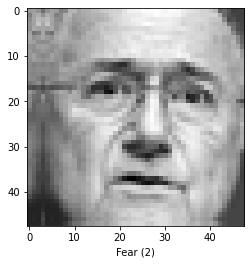

In [9]:
def showimg(data):
    img, lbl = data
    plt.figure()
    plt.imshow(torch.squeeze(img), cmap='gray')
    plt.xlabel(f'{classes[lbl]} ({lbl})')
    plt.plot()
    
showimg(train_data[5])

Now when the data is ready we will have a validation dataset and dataloader for them with batch sizes

In [10]:
random_seed = 42
torch.manual_seed(random_seed);

In [61]:
batch_num = 400

train_dl = DataLoader(train_data, batch_num, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_data, batch_num*2, num_workers=4, pin_memory=True)

Since the dataloader and eevrything is ready now, lets take a look at the photos

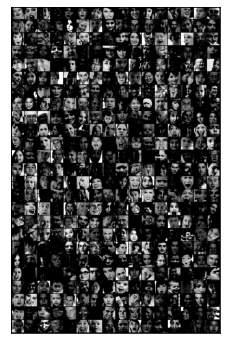

In [62]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
        
show_batch(train_dl)

Everything is completed with the data processing! Now we can begin creating our model!!

## Creating The Model

We will craete a base class for the image classification about the expression which will later be encapsuled in the class for the model

In [64]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

class FERBase(nn.Module):
    
    # this takes is batch from training dl
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                     # calls the training model and generates predictions
        loss = F.cross_entropy(out, labels)    # calculates loss compare to real labels using cross entropy
        return loss
    
    # this takes in batch from validation dl
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)            # calls the accuracy function to measure the accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()    # finds out the mean loss of the epoch batch
        
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()       # finds out the mean acc of the epoch batch
        
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
        
        

Now we will create our model for the Facial Expression Recognition

In [89]:
def conv_block(in_chnl, out_chnl, pool=False, padding=1):
    layers = [
        nn.Conv2d(in_chnl, out_chnl, kernel_size=3, padding=padding),
        nn.BatchNorm2d(out_chnl),
        nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class FERModel(FERBase):
    def __init__(self, in_chnls, num_cls):
        super().__init__()
        
        self.conv1 = conv_block(in_chnls, 64, pool=True)           # 64x24x24 
        self.conv2 = conv_block(64, 128, pool=True)                # 128x12x12
        self.resnet1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))    # Resnet layer 1: includes 2 conv2d
        
        self.conv3 = conv_block(128, 256, pool=True)       # 256x6x6 
        self.conv4 = conv_block(256, 512, pool=True)       # 512x3x3
        self.resnet2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))    # Resnet layer 2: includes 2 conv2d
        
        self.classifier = nn.Sequential(nn.MaxPool2d(3),
                                        nn.Flatten(),
                                        nn.Linear(512, num_cls))    # num_cls
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.resnet1(out) + out
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.resnet2(out) + out
        
        return self.classifier(out)
        
model = FERModel(1, 7)

Let us nowlook if the model gives us the output array as I am hoping for. The output array must contain 7 values, that is 7 probabilities of what class could it be from the expression classes.

In [91]:
for images, lbl in train_dl:
    print('shape of image: ', images.shape)
    out = model(images)
    print('shape of output: ', out.shape)
    print('Output: ', out[0])
    break

shape of image:  torch.Size([400, 1, 48, 48])
shape of output:  torch.Size([400, 7])
Output:  tensor([ 2.7221, -2.4508, -0.6657, -0.3718, -1.8639, -2.4460,  1.2414],
       device='cuda:0', grad_fn=<SelectBackward>)


Now let us code for to utilise the GPU for the training!

In [70]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [71]:
device = get_default_device()
device

device(type='cuda')

Now let us wrap our datas to the available device

In [90]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

## Training The Model

Since the model itself is ready, there is not any more headache left to create some functions for the training start training.

In [48]:
@torch.no_grad()    # this is for stopping the model from keeping track ofold parameters
def evaluate(model, val_loader):
    # This function will evaluate the model and give back the val acc and loss
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# getting the current learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# this fit function follows the intuition of 1cycle lr
def fit(epochs, max_lr, model, train_loader=train_dl, val_loader=val_dl, weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []    #keep track of the evaluation results
    
    # setting upcustom optimizer including weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # setting up 1cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # record the lr
            lrs.append(get_lr(optimizer))
            sched.step()
            
        #validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

We also need to load our model in the device too

In [108]:
model = to_device(FERModel(1, 7), device)

In [113]:
evaluate(model, val_dl)

{'val_loss': 0.9384211897850037, 'val_acc': 0.7027608752250671}

Now we will train

In [110]:
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4

In [111]:
%%time
history = fit(30, max_lr, model, weight_decay=weight_decay, grad_clip=grad_clip)

Epoch [0], last_lr: 0.00007, train_loss: 1.6198, val_loss: 1.4583, val_acc: 0.4501
Epoch [1], last_lr: 0.00015, train_loss: 1.3828, val_loss: 1.4212, val_acc: 0.4931
Epoch [2], last_lr: 0.00028, train_loss: 1.2906, val_loss: 1.2961, val_acc: 0.4834
Epoch [3], last_lr: 0.00044, train_loss: 1.2034, val_loss: 1.1675, val_acc: 0.5634
Epoch [4], last_lr: 0.00060, train_loss: 1.1608, val_loss: 1.3283, val_acc: 0.4845
Epoch [5], last_lr: 0.00076, train_loss: 1.1209, val_loss: 1.0760, val_acc: 0.5908
Epoch [6], last_lr: 0.00089, train_loss: 1.0870, val_loss: 1.1604, val_acc: 0.5626
Epoch [7], last_lr: 0.00097, train_loss: 1.0684, val_loss: 1.2007, val_acc: 0.5504
Epoch [8], last_lr: 0.00100, train_loss: 1.0300, val_loss: 1.2089, val_acc: 0.5423
Epoch [9], last_lr: 0.00099, train_loss: 1.0029, val_loss: 1.0798, val_acc: 0.5822
Epoch [10], last_lr: 0.00098, train_loss: 0.9774, val_loss: 0.9902, val_acc: 0.6249
Epoch [11], last_lr: 0.00095, train_loss: 0.9423, val_loss: 1.0140, val_acc: 0.6179
Ep

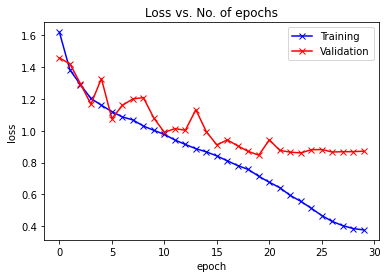

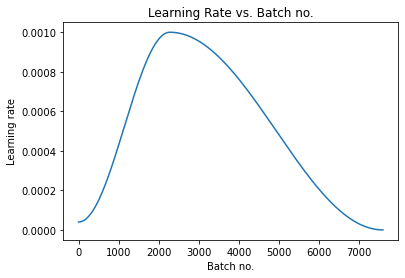

In [116]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
    
plot_losses(history)
plt.figure()
plot_lrs(history)

**History log**

* model1: 1>16>32>64>128>256>256 cnn then, 256*6*6>1024>512>7 fnn, 10epoch 0.001lr, 3epoch 0.0001lr, 55%, overfit

* model2: 1>64>128>256>512>1024 cnn then 1024*6*6>1024>512>128>7 fnn, 10epoch, 0.0001lr, 56%, minimum overfitting

* model3: 1>128>256>600>1200>2048>1024 cnn then 1024*3*3>1024>512>7 fnn, 5epochs 1e-4lr, 6epochs 1e-5lr,5epochs, 1e-6lr, 58%, minimum overfit 

* resnet9: maxlr 0.001, epochs 20-30, 69%, minimum overfit

* resnet9: maxlr 0.01, epoch 20, 71%

* resnet9: maxlr 0.001, 30 epcohs, 72%

## Saving the Model

Now since the training is done we can succesfully save our model so that we can use it in our facial recognition script!

In [117]:
torch.save(model.state_dict(), 'FER2013-Resnet9.pth')